## Building A Handwritten Digits Classifier

In this project, we'll explore why image classification is a hard task, observe the limitations of traditional machine learning models for image classification and train, test, and improve a few different deep neural networks for image classification.

We'll use a pre-loaded dataset from the library `sklearn`, specifically, we'll use the `load_digits()` function that returns a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI (University of California, Irvine).

### 1. Exploring the dataset

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (8 x 8 pixels). To visualize the image, we need to reshape these pixel values back into the 8 by 8 and plot them on a coordinate grid.

Data shape:  (1797, 64)
Target shape:  (1797,)


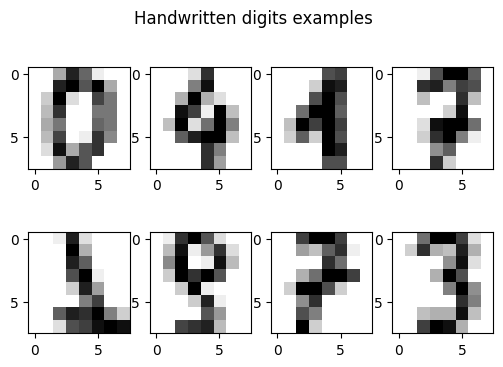

In [1]:
# Loading the dataset
from sklearn.datasets import load_digits
digits = load_digits()
print('Data shape: ', digits.data.shape)
print('Target shape: ', digits.target.shape)

# Creating dataframes
import pandas as pd 

data = pd.DataFrame(digits.data)
labels = pd.Series(digits.target)

# Visualizing a few examples
%matplotlib inline
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4)
fig.suptitle('Handwritten digits examples')

ax1.imshow(data.iloc[0].values.reshape(8, 8), cmap='gray_r')
ax2.imshow(data.iloc[100].values.reshape(8, 8), cmap='gray_r')
ax3.imshow(data.iloc[200].values.reshape(8, 8), cmap='gray_r')
ax4.imshow(data.iloc[300].values.reshape(8, 8), cmap='gray_r')
ax5.imshow(data.iloc[1000].values.reshape(8, 8), cmap='gray_r')
ax6.imshow(data.iloc[1100].values.reshape(8, 8), cmap='gray_r')
ax7.imshow(data.iloc[1200].values.reshape(8, 8), cmap='gray_r')
ax8.imshow(data.iloc[1300].values.reshape(8, 8), cmap='gray_r')

plt.show()

### 2. K-Nearest Neighbor Algorithm

The k-nearest neighbor algorithm make no assumptions about the linearity between the features and the output labels, this allow it to capture nonlinearity in the data.

The k-nearest neighbors algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

Mean_accuracy for k = 1: 0.9877604553328385
Mean_accuracy for k = 2: 0.9849752536500865
Mean_accuracy for k = 3: 0.9872011878247959
Mean_accuracy for k = 4: 0.984974016332591
Mean_accuracy for k = 5: 0.9866406829992576
Mean_accuracy for k = 6: 0.9849690670626082
Mean_accuracy for k = 7: 0.9838567186340015
Mean_accuracy for k = 8: 0.9833024003959415
Mean_accuracy for k = 9: 0.9805196733481811
Mean_accuracy for k = 10: 0.9805196733481811


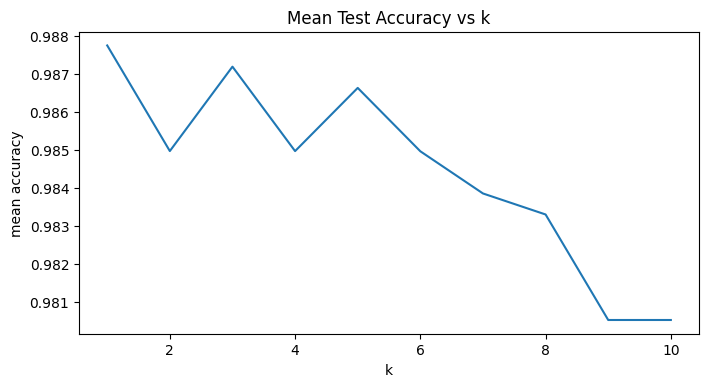

In [2]:
# k-nearest algorithm

def train(k):
    """
        This function returns the k neighbor model.
    """
    from sklearn.neighbors import KNeighborsClassifier
    
    return KNeighborsClassifier(n_neighbors=k)

def test(knn, X, y):
    """
        This function returns the mean accuracy on the given test data and labels.
    """
    return knn.score(X, y)
    
def cross_validate(data, labels, k):
    """
        This function performs a 4-fold cross validation using the k-nearest algorithm and returns its accuracy.
    """
    from sklearn.model_selection import cross_val_score, KFold
    
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    knn = train(k)
    accuracies = cross_val_score(knn, data, labels, scoring=test, cv=kf)
    return accuracies
    
# execution
import numpy as np

k_values = range(1, 11)
k_mean_accuracies = []

for k in k_values:
    accuracies = cross_validate(data, labels, k)
    mean_accuracy = np.mean(accuracies)
    print('Mean_accuracy for k = {}: {}'.format(k, mean_accuracy))
    k_mean_accuracies.append(mean_accuracy)
    
plt.figure(figsize=(8, 4))
plt.title("Mean Test Accuracy vs k")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(k_values, k_mean_accuracies)
plt.show()

### 3. MLP Feedforward Neural Network

Deep learning is effective in image classification because of the models' ability to learn hierarchical representations. At a high level, an effective deep learning model learns intermediate representations at each layer in the model and uses them in the prediction process. Here, we'll explore the effectiveness of deep, feedforward neural networks at classifying images.

In [3]:
# Definition of the feedforward neural network
def train_nn(X_train, y_train, l, n):
    """
        This function returns the trained NN model with l number of layers and n number of neurons for each layer.
    """
    import warnings
    from sklearn.neural_network import MLPClassifier
    from sklearn.exceptions import ConvergenceWarning
    
    layers = tuple(l*[n])
    mlp = MLPClassifier(random_state=42, hidden_layer_sizes=layers, activation='logistic', n_iter_no_change=3, learning_rate_init=0.01)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp = mlp.fit(X_train, y_train)
    train_score = mlp.score(X_train, y_train)
    return mlp, train_score
    
def test_nn(mlp, X_test, y_test):
    """
        This function returns the accuracy score on the given test data and labels.
    """
    test_score = mlp.score(X_test, y_test)
    return test_score

def cross_validate_nn(data, labels, l, n, s):
    """
        This function performs a s-fold cross validation using the NN model and returns its mean accuracy.
    """
    from sklearn.model_selection import KFold
    
    data = np.asarray(data)
    labels = np.asarray(labels)
    
    train_scores = list()
    test_scores = list()
    kf = KFold(n_splits=s, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(data, labels):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        mlp, train_score = train_nn(X_train, y_train, l, n)
        test_score = test_nn(mlp, X_test, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)
    return mean_train_score, mean_test_score

#### 3.1. Neural Network with one hidden layer

 >> Results for 8 neurons:
Training set score: 0.990354
Test set score: 0.917081

 >> Results for 16 neurons:
Training set score: 0.998887
Test set score: 0.955483

 >> Results for 32 neurons:
Training set score: 1.000000
Test set score: 0.964937

 >> Results for 64 neurons:
Training set score: 1.000000
Test set score: 0.973284

 >> Results for 128 neurons:
Training set score: 1.000000
Test set score: 0.974401

 >> Results for 256 neurons:
Training set score: 1.000000
Test set score: 0.974955



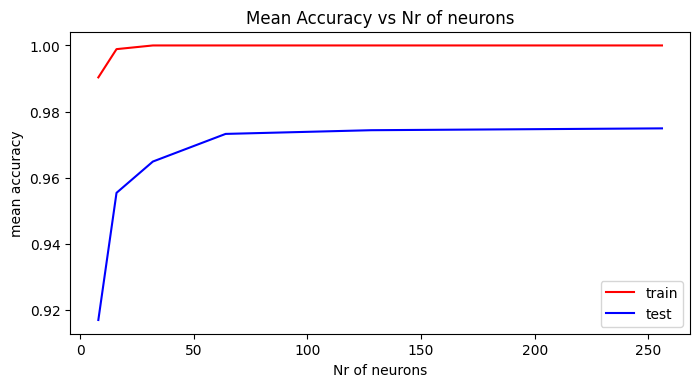

In [4]:
neuron_values = [8, 16, 32, 64, 128, 256]
train_nn_accuracies = []
test_nn_accuracies = []

for n in neuron_values:
    mean_train_score, mean_test_score = cross_validate_nn(data, labels, 1, n, 4)
    train_nn_accuracies.append(mean_train_score)
    test_nn_accuracies.append(mean_test_score)
    print(" >> Results for {} neurons:".format(n))
    print("Training set score: %f" % mean_train_score)
    print("Test set score: %f" % mean_test_score)
    print()
    
    
plt.figure(figsize=(8, 4))
plt.title("Mean Accuracy vs Nr of neurons")
plt.xlabel("Nr of neurons")
plt.ylabel("mean accuracy")
plt.plot(neuron_values, train_nn_accuracies, 'r', label='train')
plt.plot(neuron_values, test_nn_accuracies, 'b', label='test')
plt.legend()
plt.show()

Adding more neurons to a single hidden layer vastly improved the classification accuracy.

#### 3.2. Neural Network with two hidden layers

 >> Results for 8 neurons:
Training set score: 0.971988
Test set score: 0.893697

 >> Results for 16 neurons:
Training set score: 0.999444
Test set score: 0.948247

 >> Results for 32 neurons:
Training set score: 1.000000
Test set score: 0.958262

 >> Results for 64 neurons:
Training set score: 1.000000
Test set score: 0.975516

 >> Results for 128 neurons:
Training set score: 1.000000
Test set score: 0.974397

 >> Results for 256 neurons:
Training set score: 1.000000
Test set score: 0.973289



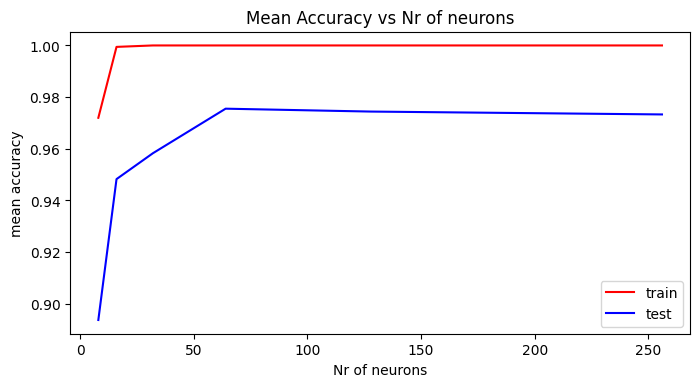

In [5]:
neuron_values = [8, 16, 32, 64, 128, 256]
train_nn_accuracies = []
test_nn_accuracies = []

for n in neuron_values:
    mean_train_score, mean_test_score = cross_validate_nn(data, labels, 2, n, 4)
    train_nn_accuracies.append(mean_train_score)
    test_nn_accuracies.append(mean_test_score)
    print(" >> Results for {} neurons:".format(n))
    print("Training set score: %f" % mean_train_score)
    print("Test set score: %f" % mean_test_score)
    print()
    
    
plt.figure(figsize=(8, 4))
plt.title("Mean Accuracy vs Nr of neurons")
plt.xlabel("Nr of neurons")
plt.ylabel("mean accuracy")
plt.plot(neuron_values, train_nn_accuracies, 'r', label='train')
plt.plot(neuron_values, test_nn_accuracies, 'b', label='test')
plt.legend()
plt.show()

Same as before, adding more neurons help the network perfomance. However, adding another hidden layer does not improve the overall accuracy.

#### 3.3. Neural Network with three hidden layers

Using more hidden layers is known to increase the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers.

 >> Results for 8 neurons:
Training set score: 0.789433
Test set score: 0.708920

 >> Results for 16 neurons:
Training set score: 0.986420
Test set score: 0.929890

 >> Results for 32 neurons:
Training set score: 1.000000
Test set score: 0.960487

 >> Results for 64 neurons:
Training set score: 1.000000
Test set score: 0.968292

 >> Results for 128 neurons:
Training set score: 1.000000
Test set score: 0.974963

 >> Results for 256 neurons:
Training set score: 0.994214
Test set score: 0.964944



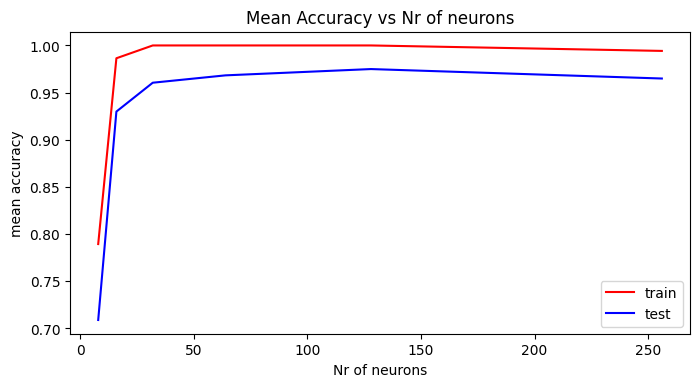

In [6]:
neuron_values = [8, 16, 32, 64, 128, 256]
train_nn_accuracies = []
test_nn_accuracies = []

for n in neuron_values:
    mean_train_score, mean_test_score = cross_validate_nn(data, labels, 3, n, 6)
    train_nn_accuracies.append(mean_train_score)
    test_nn_accuracies.append(mean_test_score)
    print(" >> Results for {} neurons:".format(n))
    print("Training set score: %f" % mean_train_score)
    print("Test set score: %f" % mean_test_score)
    print()
    
    
plt.figure(figsize=(8, 4))
plt.title("Mean Accuracy vs Nr of neurons")
plt.xlabel("Nr of neurons")
plt.ylabel("mean accuracy")
plt.plot(neuron_values, train_nn_accuracies, 'r', label='train')
plt.plot(neuron_values, test_nn_accuracies, 'b', label='test')
plt.legend()
plt.show()

Results do not improve compared with the cases with one or two hidden layers. Moreover, the best general accuracy was obtained with the k neighbor algorithm.

We can see that MLP feedforward neural networks tend to a fast overtfit for this dataset. This situation is more pronounced as we increase the number of layers and neurons, i.e., the __variance__ of the model. For low number of neurons for each layer we see that the model does not perform well. The reason is that the model has a high __bias__ as it has few parameters to fit to the data, i.e., low variance. This scenario is known as the __bias-variance__ tradeoff. Regularly, a high number in one of them implies a low number for the other, and vice versa.